# Example for point source parameter estimation with SWYFT

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
NDIM = 5 # number of parameters

In [52]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    threshold = z[5]*5.
    x = np.linspace(-5, 5, 50, 50)
    X, Y = np.meshgrid(x,x)
    diff = np.cos(X+z[1]*2)*np.cos(Y+z[2]*2)*z[0] + 2
    p = np.random.randn(*X.shape)*z[4]-0.3
    psc = 10**p*z[3]
    n = np.random.randn(*X.shape)*sigma
    out = (diff*5 + psc + n)
    det = psc>(diff*5 + threshold*sigma)
    return np.array([det, out])

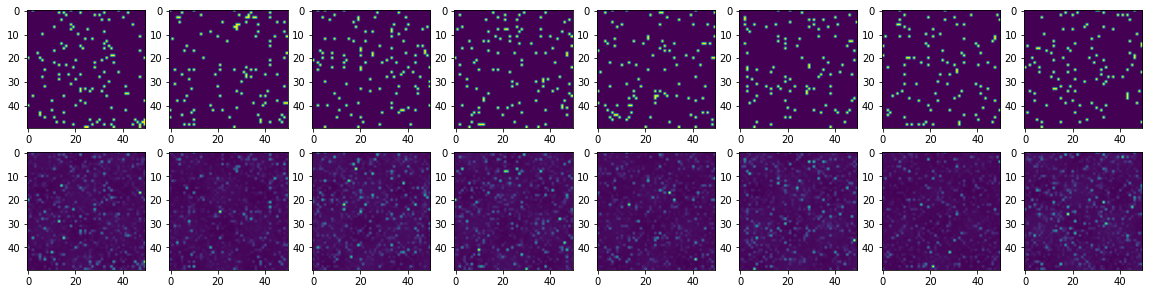

In [81]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(4, 8, i+1)
    z0 = np.random.rand(6)
    z0 = np.array([0.1, 0.2, 0.8, 0.4, 1.0, 0.5])
    x0 = model(z0)
    plt.imshow(x0[0])
    plt.subplot(4, 8, i+1 + 8)
    plt.imshow(np.log(x0[1]))

z0 = np.array([0.1, 0.2, 0.8, 0.4, 1.0, 0.5])
x0 = model(z0)

In [82]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(2, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(2, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        #x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [ ]:
# Instantiate network

sw = swyft.SWYFT(x0, model, zdim = 6, device = DEVICE, head = Head)
sw.run(nrounds = 3, max_epochs = 100, early_stopping_patience = 2, recycle_net = False, nsamples = 10000, nbatch = 32)

Adding samples.: 100%|██████████| 10006/10006 [00:00<00:00, 44820.92it/s]


Adding 10006 new samples.


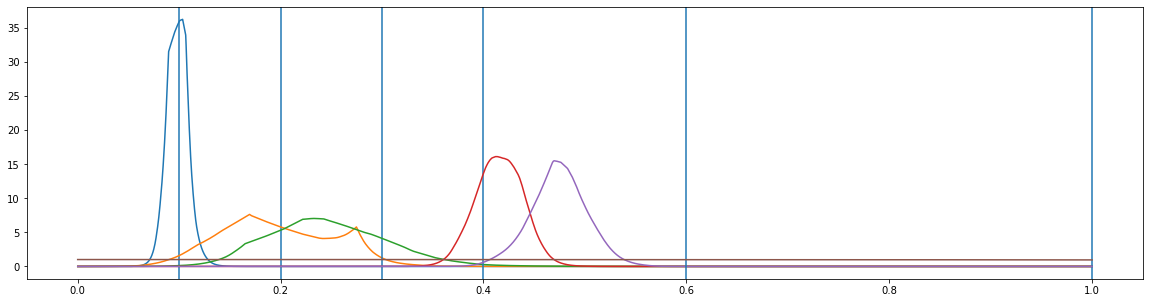

In [79]:
#z0 = np.array([0.1, 0.2, 0.3, 0.4, 1.0, 0.6])
#x0 = model(z0)

plt.figure(figsize=(20, 5))
for i in range(6):
    z, p = sw.posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p)